<a href="https://colab.research.google.com/github/sofia-sunny/Basic/blob/main/warfarin_alternative2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using Tanimoto Similarity Search to Find a Natural Compound Alternative to Warfarin**
Warfarin is a commonly prescribed anticoagulant, or blood thinner, used to prevent blood clots that can cause serious conditions like stroke and heart attack. While effective, it requires regular monitoring of blood levels to ensure it stays within a safe therapeutic range. Additionally, warfarin use comes with several potential side effects, including an increased risk of bleeding, bruising, and gastrointestinal issues. The need for frequent blood tests and dietary restrictions further complicates treatment and can make it challenging for patients to maintain proper compliance.Therefore, there is a growing need to find alternatives to warfarin, including exploring natural compounds as potential sources.
Here, we explore a subset of  [COCONUT Natural Compounds ](https://coconut.naturalproducts.net/)database to identify a natural compound with high Tanimoto similarity, aiming to find a potential alternative to warfarin.



In [ ]:
!pip install useful_rdkit_utils mols2grid

Importing necessary libraries

In [ ]:
import useful_rdkit_utils as uru
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import TanimotoSimilarity
from tqdm.auto import tqdm
from rdkit.Chem import Draw
import mols2grid
from rdkit.rdBase import BlockLogs
import pandas as pd

Using tqdm to create progress bars

In [ ]:
tqdm.pandas()

In [ ]:
df = pd.read_csv('Coco_DB.csv')

In [ ]:
df

,ID,SMILES
0,CNP0282693.1,COC1=CC=CC2=C1C(=O)C1=C(O)C3=C(C[C@@](O)(C(=O)...
1,CNP0214016.1,COC1=CC2=CC(=C1Cl)N(C)C(=O)C[C@H](OC(=O)[C@H](...
2,CNP0185052.1,NC1=NC(N)=C2N=C(CNC3=CC=C(C(=O)N[C@@H](CCCNC(=...
3,CNP0074548.1,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(COC...
4,CNP0602851.1,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...
...,...,...
9995,CNP0280738.0,CC1=NOC2=CC=NN=C12
9996,CNP0173963.0,N=C1ONC2=CC=NC=C12
9997,CNP0000957.0,OC1=CN=NC2=C1NC=C2
9998,CNP0191383.0,N=C1C=NN2C=CC=C2O1


In [ ]:
# Borrowed from https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/
# https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
def standardize(smiles):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb


    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger()  # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.

    te = rdMolStandardize.TautomerEnumerator()  # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)

    return Chem.MolToSmiles(taut_uncharged_parent_clean_mol)

In [ ]:
with BlockLogs():
    df['std_smiles'] = df.SMILES.progress_apply(standardize)

  0%|          | 0/10000 [00:00<?, ?it/s]

Let's see how many SMILES were standardized:

In [ ]:
df_diff = df[df['std_smiles'] != df['SMILES']]

In [ ]:
df_diff.shape

(6909, 3)

In [ ]:
df['SMILES']  = df['std_smiles']

In [ ]:
df.drop(columns=['std_smiles'], inplace=True)

In [ ]:
df

,ID,SMILES
0,CNP0282693.1,COc1cccc2c(O)c3c(c(O)c12)C(=O)C1=C(C[C@@](O)(C...
1,CNP0214016.1,COc1cc2cc(c1Cl)N(C)C(=O)C[C@H](OC(=O)C(C)N(C)C...
2,CNP0185052.1,Nc1nc(N)c2nc(CNc3ccc(C(=O)NC(CCCNC(=O)c4ccccc4...
3,CNP0074548.1,CON=C(C(=O)NC1C(=O)N2C(C(=O)O)=C(COC(N)=O)CS[C...
4,CNP0602851.1,CON=C(C(=O)NC1C(=O)N2C(C(=O)[O-])=C(C[n+]3cccc...
...,...,...
9995,CNP0280738.0,Cc1noc2ccnnc12
9996,CNP0173963.0,Nc1onc2ccncc12
9997,CNP0000957.0,O=c1cn[nH]c2cc[nH]c12
9998,CNP0191383.0,N=c1cnn2cccc2o1


In [ ]:
df['mol'] = df['SMILES'].progress_apply(Chem.MolFromSmiles)

  0%|          | 0/10000 [00:00<?, ?it/s]

**Adding the fingerprints**

In [ ]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

In [ ]:
df['fp'] = df['mol'].progress_apply(mfpgen.GetFingerprint)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
df.head()

,ID,SMILES,mol,fp
0,CNP0282693.1,COc1cccc2c(O)c3c(c(O)c12)C(=O)C1=C(C[C@@](O)(C...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a11bd0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CNP0214016.1,COc1cc2cc(c1Cl)N(C)C(=O)C[C@H](OC(=O)C(C)N(C)C...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a11930>,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CNP0185052.1,Nc1nc(N)c2nc(CNc3ccc(C(=O)NC(CCCNC(=O)c4ccccc4...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a10f20>,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,CNP0074548.1,CON=C(C(=O)NC1C(=O)N2C(C(=O)O)=C(COC(N)=O)CS[C...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a115b0>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CNP0602851.1,CON=C(C(=O)NC1C(=O)N2C(C(=O)[O-])=C(C[n+]3cccc...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a11e00>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
warfarin_smiles = 'CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O'
warfarin_mol = Chem.MolFromSmiles(warfarin_smiles)
warfarin_fp = mfpgen.GetFingerprint(warfarin_mol)


In [ ]:
df['Tanimoto'] = df['fp'].apply(lambda fp: TanimotoSimilarity(warfarin_fp, fp))
df.head()

,ID,SMILES,mol,fp,Tanimoto
0,CNP0282693.1,COc1cccc2c(O)c3c(c(O)c12)C(=O)C1=C(C[C@@](O)(C...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a11bd0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.193182
1,CNP0214016.1,COc1cc2cc(c1Cl)N(C)C(=O)C[C@H](OC(=O)C(C)N(C)C...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a11930>,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.098214
2,CNP0185052.1,Nc1nc(N)c2nc(CNc3ccc(C(=O)NC(CCCNC(=O)c4ccccc4...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a10f20>,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.119565
3,CNP0074548.1,CON=C(C(=O)NC1C(=O)N2C(C(=O)O)=C(COC(N)=O)CS[C...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a115b0>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.134831
4,CNP0602851.1,CON=C(C(=O)NC1C(=O)N2C(C(=O)[O-])=C(C[n+]3cccc...,<rdkit.Chem.rdchem.Mol object at 0x7eeea5a11e00>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.094340


In [ ]:
df.sort_values('Tanimoto', ascending=False)

,ID,SMILES,mol,fp,Tanimoto
2483,CNP0415634.0,CCOC(=O)C(c1c(O)c2ccccc2oc1=O)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7eeea7c0d690>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.574468
8250,CNP0001242.0,CC(=O)Cc1nc2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7eeea7c60820>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.380000
2472,CNP0415625.0,O=c1c(Cc2c(O)oc3ccccc3c2=O)c(O)oc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7eeea7c0d1c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.361702
6230,CNP0387917.0,C=c1c(O)c2cccc(O)c2c(O)c1=c1c(O)c2c(=C)cccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7eeea7c98c80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.345455
2334,CNP0215909.0,O=c1c2ccccc2oc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7eeea7c254d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.341463
...,...,...,...,...,...
3753,CNP0539310.0,[Ag],<rdkit.Chem.rdchem.Mol object at 0x7eeea7bff840>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
2877,CNP0077173.0,C1CC2CCCN2C1,<rdkit.Chem.rdchem.Mol object at 0x7eeea7c044a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
3643,CNP0566975.0,[Sm],<rdkit.Chem.rdchem.Mol object at 0x7eeea7c01690>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
9350,CNP0343670.0,S1SSSSSSS1,<rdkit.Chem.rdchem.Mol object at 0x7eeea7c42d50>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000


The molecule with highest Tanimoto similarity of 0.57 share some structural features with Warfarin but still have significant differences.
Let's have a look!

In [ ]:
sim_mol = df['mol'][2483] # mol with highest Tanimoto similarity
sim_mol

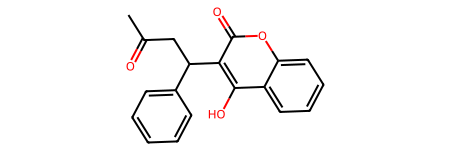

In [ ]:
warfarin_mol

Let's check the Lipinski rule for the the similar_compound

In [ ]:
def lipinski_check(mol):

    # Calculate Lipinski descriptors
    mol_weight = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)

    # Check if the molecule passes Lipinski's Rule of Five
    if mol_weight <= 500 and logp <= 5 and hbd <= 5 and hba <= 10:
        return "Passes Lipinski's Rule"
    else:
        return "Fails Lipinski's Rule"

In [ ]:
lipinski_check(sim_mol)

"Passes Lipinski's Rule"


The moderate similarity  and passing the Lipinski rule suggest that the compound  could be a starting point for exploring structural analogs of Warfarin.